**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    
    if previous_action != None:
      #update value of action count
      self.N[previous_action] += 1
      #update value of Q - estimate new action value for the previous action
      self.Q[previous_action] += (1. / self.N[previous_action]) * (reward - self.Q[previous_action])
    
    #increment the time step
    self.t += 1

    #get new action 
    #untried/ unexplored action should be selected prior to selecting any same action again
    ut = np.argwhere(self.N == 0).flatten()
    if ut.size != 0:
      #select unexplored action
      action = np.random.choice(ut)
    else:
      #select new action that maximized UCB
      act = self.Q + self.bonus_multiplier * np.sqrt(np.log(self.t)/self.N)
      action = argmax(act)

    return action

  def reset(self):
    #initialise total no of time step
    self.t =0

    #initialise Q values for each arm of bandit
    self.Q = np.zeros(self._number_of_arms)

    #set count for each action
    self.N = np.zeros(self._number_of_arms)

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self.epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """

    # Update values
    if previous_action != None:
      #update value of action count
      self.N[previous_action] += 1
      #update value of Q
      self.Q[previous_action] += (1. / self.N[previous_action]) * (reward - self.Q[previous_action])
    
    self.t += 1
    #increment the time step


    # Get new action

    #check if epsilon is callable or scalar
    epsilon = self.epsilon(self.t) if callable(self.epsilon) else self.epsilon
    
    if np.random.rand() < epsilon:
      # Explore, pick random action less than epsilon
      action = np.random.randint(self._number_of_arms)
    else:
      # Exploit, pick highest Q value
      action = argmax(self.Q)

    return action      

  def reset(self):
    #initialise total no of time step
    self.t = 0
    #initialise Q values for each arm of bandit
    self.Q = np.zeros(self._number_of_arms)
    #set count for each action
    self.N = np.zeros(self._number_of_arms) 

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._number_of_arms = number_of_arms
    self.step_size = step_size
    self.baseline = baseline
    self.reset()

  def step(self, previous_action, reward):

    #compute square max probs
    action_probabilities = np.square(self.H) / np.sum(np.square(self.H))

    # Update values
    if previous_action != None:

      # refer sutton Baseline update if it is applicable
      if self.baseline:
        self.baseline_average_reward += self.step_size * (reward - self.baseline_average_reward)
        
      # Gradient update
      #indicator function for selected actions, ow zero
      indicator = np.zeros_like(action_probabilities)
      indicator[previous_action] = 1

      if self.baseline:
        self.H = self.H + self.step_size * (reward - self.baseline_average_reward) * 2 * (indicator / self.H - action_probabilities / self.H)
      else:
        self.H = self.H + self.step_size * reward * 2 * (indicator / self.H - action_probabilities / self.H)

    #increment time step
    self.t += 1
      
    # Get new action randomly
    action = np.random.choice(np.arange(self._number_of_arms), p=action_probabilities)

    return action

  def reset(self):
    self.baseline_average_reward = 0
    self.t = 0
    self.H = np.ones(self._number_of_arms)

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

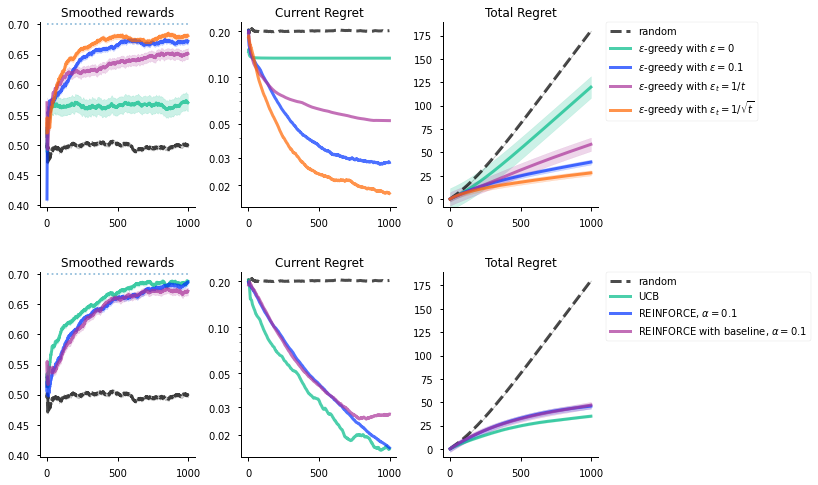

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

Answer - 

1. **Random** - A random stochastic policy is the one where actions are picked randomly. These actions are not picked in a way to reduce the total regret, thus, we do not expect it to perform well. Since we have a Bernoulli Bandit problem, there are two possible outcomes for each action which means each action has a 50% chance of being selected and this is the reason why our total reward settles at 0.5.

2. **ϵ-greedy:** The regret for ϵ-greedy increases linearly with time. Since we are exploiting actions which give us a higher reward, we expect it to perform better than random policy. When we decay our ϵ value wrt time, it allows us to reduce the amount of exploration when enough exploration has already been done which helps us obtain better results. 

3. **UCB:** UCB explores every action eventually, and looks for actions that have the potential to be optimal. But, actions that have already been selected or actions with low estimates will not be selected frequently. Thus, the algorithm exploits in a way that is recognises uncertainty, focuses on minimizing regret while still exploring. Thus, in general, UCB ends up performing well.

4. **REINFORCE:** This algorithm builds a probabilistic distribution over the actions and the aim of the algorithm is to minimize the regret  by maximizing the return by optimizing the policy. Thus, the algorithm is expected to work better. When we include the baseline, its helps us to increase the computation speed and reduce the variance.

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

Answer - Ranked worst to best-

1. $\epsilon$ = 0 , the algorithm tries each arm randomly until it finds the first success. When it gets the first success, it starts to exploit this arm repeatedly. Thus, the algorithm performs worst with $\epsilon$ = 0 

2. $\epsilon = 1/t$ , in the beginning, the algorithm uses pure greedy approach and improves quickly because of time step (t). This allows early exploration. The agent is able to work on which action provides the highest reward but the actions are not explored well enough as the epsilon decay is too fast.

3. $\epsilon = 0.1$ , throughout training, this algorithm allows continuous exploration which helps agent to come up with a better model for each action.

4. $\epsilon = 1/\sqrt{t}$ , works the best. This is because though the epsilon decreases, it isn't fast enough which works great as it allows enough exploration time for the agent to find near optimal solution. After the early exploration, as the epsilon decays to a smaller value, the agent converges on the actions with a high expected reward.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

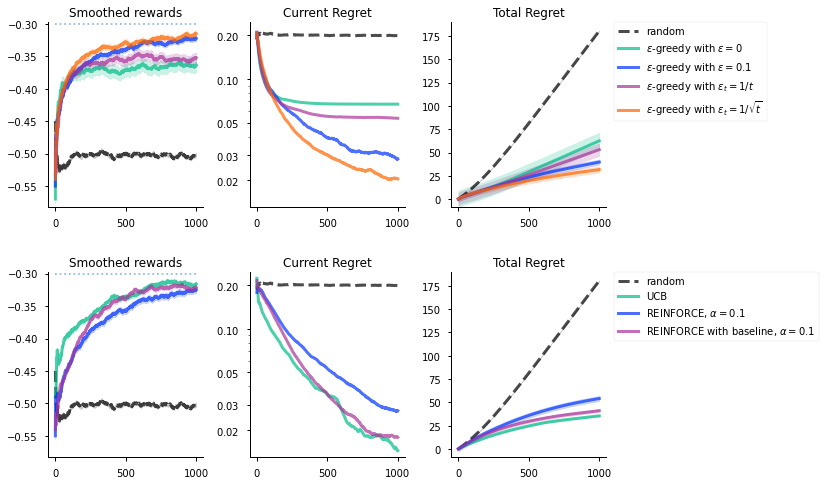

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

 Answer -
1. $\epsilon = 0$ : We see significant changes because the initial rewards estimates and success rewards, both are zero. The initialising of Q=0 for every action, we get optimistic initialisation which results in all actions being explored initially and the algorithm continues to choose the most rewarding of the explored actions.

2. $\epsilon = 0.1$ : We see no significant changes because the exploration amount is already relatively high. Thus, optimisitic initial value doesn't do much but definitely helps to find a better solution quickly. 

3. $\epsilon = 1/t :$ We see significant changes but less than $\epsilon =0$. The amount of exploration decreases relatively quickly and the optimistic initial values more likely gives some kind of prior knowledge which encourages more exploration.

4. $\epsilon = 1/\sqrt{t}:$ No significant changes. The algorithm still works well and explores enough to find a near optimal solution with high reward actions. This early exploration is not dependent on the rewards received.

5. **UCB:** The UCB continues to work best in experiment 2 as well with hardly any changes because UCB picks actions that are not tried yet and always encourages exploration of every action at the start and also continues to explore actions throughout the training.

6. **Reinforce with and without baseline:**  There is slight to no  improvement in experiment 2 because the algorithm is based on updating the preferences of actions and does not focus on the action value updates. Thus, it doesn't have any significance with how the values have been initialized.

7. **Random:** The performance doesn't change because a stochastic policy picks any action with the same probability. 

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

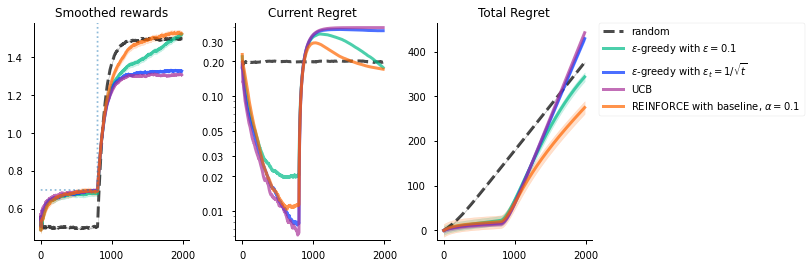

In [15]:
experiment3.show()

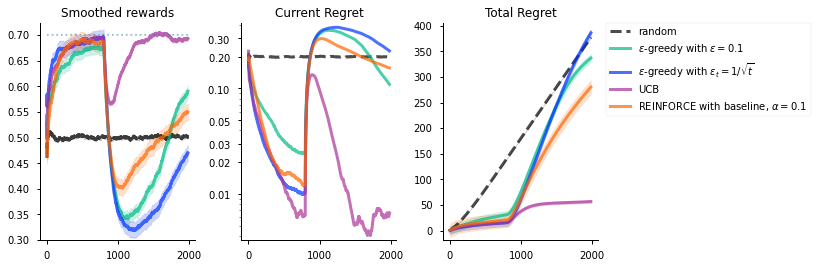

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms. This is because 

> Answer - After 800 steps, we see that the Reinforce with baseline is the most efficient because when it updates the baseline and policy, it gives weightage to recent actions and rewards more than the past actions. This is followed by the ϵ-greedy algorithm with ϵ=0.1 which takes more steps to adapt. This is because both of the algorithms continue to select low yielding reward actions even later in the training. Thus, they will select action which now yields high rewards. ϵ-greedy with ϵ=1/$\sqrt{t}$ doesn't do well as at this point it do not explore much and the worst one is UCB. Since it had high certaninty in the arm, it exploits by 800 steps. After 800 steps, the certainty associated with it gets low and UCB follow the same strategy which leads to greater regret than choosing at random

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> We see that in experiment 4 UCB is the most efficient one adapting fastest to the new changes in the rewards because the algorithm goes through enough exploration to lower the uncertainties associated with each action. 
Next is Reinforce with baseline which allows algorithm to adapt because of its baseline term and exponential recently weighted average, and its preference for solution before 800 steps reduces as it wont give such a higher average reward and continue to look for an optimal solution.
Then is ϵ-greedy algorithm with ϵ=0 which also performs fine to the new settng by continuing to explore lower predicted reward actions and update to the new rewards.
ϵ-greedy algorithm with ϵ=$1/\sqrt{t}$ is the slowest to adapt to changes but performs better in experiment 4 as it can exploit the high reward action that was found by 800 steps and wouldn't have to explore further.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> In experiment 3, UCB gets highly certain in its solution by 800 steps, and has very little reason to consider the previous failure actions. Thus, continuing with the same strategy, UCB will take a long time in order to select the previously low reward actions. This is the reason why graph of regret remains significantly high. In experiment 4, the expected rewards for selecting the same actions is decreased at a rapid rate thus allowing for selection and exploitation of new high reward actions at a much earlier stage.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> UCB can be improved in the non-stationary environment by Discounted UCB algorithm, i.e. discounting the actions taken, giving more weightage to the actions which have been taken recently and less weightage and confidence in the past rewards. This would mean that the upper bound term is quick to forget that it has previously selected the same action in the past and continues to do select same action maybe multiple time. In doing so, it quickly learns to adapt to the new environment changes.
UCB can also be improved by using the Sliding Window UCB which works in a similar fashion where only a local empirical average of rewards is used to construct the upper confidence bound frame for reward estimates and this leads to the algorithm considering only a particular set of recent actions while computing reward estimates.
